In [ ]:
pip install datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, GlobalAveragePooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D,Flatten

import unicodedata
import re

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter


In [ ]:
from datasets import load_dataset


dataset = load_dataset("ImperialCollegeLondon/health_fact")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.61k [00:00<?, ?B/s]

health_fact.py:   0%|          | 0.00/7.08k [00:00<?, ?B/s]

The repository for ImperialCollegeLondon/health_fact contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/ImperialCollegeLondon/health_fact.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/9832 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1235 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1225 [00:00<?, ? examples/s]

In [ ]:
print(len(dataset['train']), len(dataset['test']), len(dataset['validation']))


9832 1235 1225


In [ ]:
train = dataset['train']
test = dataset['test']
validation = dataset['validation']

In [ ]:
##REVISAR DATOS
print(dataset['train'].to_pandas().head(5))

  claim_id                                              claim  \
0    15661  "The money the Clinton Foundation took from fr...   
1     9893    Annual Mammograms May Have More False-Positives   
2    11358  SBRT Offers Prostate Cancer Patients High Canc...   
3    10166  Study: Vaccine for Breast, Ovarian Cancer Has ...   
4    11276  Some appendicitis cases may not require ’emerg...   

       date_published                                        explanation  \
0      April 26, 2015  "Gingrich said the Clinton Foundation ""took m...   
1    October 18, 2011  This article reports on the results of a study...   
2  September 28, 2016  This news release describes five-year outcomes...   
3    November 8, 2011  While the story does many things well, the ove...   
4  September 20, 2010  We really don’t understand why only a handful ...   

                                       fact_checkers  \
0                                      Katie Sanders   
1                                       

In [ ]:
# Ver etiquetas únicas en cada conjunto
print("Etiquetas en train:", dataset['train'].unique('label'))
print("Etiquetas en test:", dataset['test'].unique('label'))
print("Etiquetas en validation:", dataset['validation'].unique('label'))
####creo que el valor de las etiquetas es label_list = ["false", "mixture", "true", "unproven"], 0 falso,1 mix,2 verdad, 3 dudoso, -1 missing

Etiquetas en train: [0, 1, 2, 3, -1]
Etiquetas en test: [0, 2, 3, 1, -1]
Etiquetas en validation: [3, 2, 0, 1, -1]


In [ ]:
train = pd.DataFrame(train)
test = pd.DataFrame(test)
val = pd.DataFrame(validation)


REVISAR MISSING

In [ ]:
# Contar la cantidad de registros por cada categoría en la columna 'label'
print(train['label'].value_counts())


label
 2    5078
 0    3001
 1    1434
 3     291
-1      28
Name: count, dtype: int64


QUITAR MISSINGS

In [ ]:
train = train.query("label != -1")
test = test.query("label != -1")
val= val.query("label != -1")

In [ ]:
print(train['label'].value_counts())

label
2    5078
0    3001
1    1434
3     291
Name: count, dtype: int64


Pre-prosesamiento de los datos.  
Cambiamos a minúscula, quitamos acentos y ciertos caracteres de puntuación

In [ ]:
def preprocess_text(text):
    # Remove accents
    text = ''.join(
        (c for c in unicodedata.normalize('NFD', text)
        if unicodedata.category(c) != 'Mn')
    )

    # Convert to lowercase
    text = text.lower()

    # Remove dots and commas, but keep other punctuation
    text = re.sub(r'[.,]', '', text)

    return text



In [ ]:
l

In [ ]:
# Aplicar la funcin a

###maintext
train['main_text'] = train['main_text'].apply(preprocess_text)
print(train['main_text'].values)

test['main_text'] = test['main_text'].apply(preprocess_text)
print(test['main_text'].values)

val['main_text'] = val['main_text'].apply(preprocess_text)
print(val['main_text'].values)




['"hillary clinton is in the political crosshairs as the author of a new book alleges improper financial ties between her public and personal life at issue in conservative author peter schweizer’s forthcoming book clinton cash are donations from foreign governments to the clinton foundation during the four years she served as secretary of state george stephanopoulos used an interview with schweizer on abc this week to point out what other nonpartisan journalists have found: there is no ""smoking gun"" showing that donations to the foundation influenced her foreign policy decisions still former republican house speaker newt gingrich says the donations are ""clearly illegal"" under federal law in his view a donation by a foreign government to the clinton foundation while clinton was secretary of state is the same as money sent directly to her he said even though she did not join the foundation’s board until she left her post ""the constitution of the united states says you cannot take mo

In [ ]:
# Seleccionar solo las columnas
X_train = train['main_text']
y_train = train['label']
X_val = val['main_text']
y_val = val['label']
X_test = test['main_text']
y_test = test['label']


# Verificar las dimensiones
print(f"Train: {len(y_train)}, Validation: {len(y_val)}, Test: {len(y_test)}")


Train: 9804, Validation: 1214, Test: 1233


In [ ]:
  # PROBAR QUE SEAN DEL MISMO TAMAÑO
print(len(X_train), len(y_train))
print(len(X_val), len(y_val))
print(len(X_test), len(y_test))


9804 9804
1214 1214
1233 1233


In [ ]:
###Hacer las clases categoricas

from tensorflow.keras.utils import to_categorical

num_classes = len(np.unique(y_train))

y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)
y_test = to_categorical(y_test, num_classes)
print(f"Train: {len(y_train)}, Validation: {len(y_val)}, Test: {len(y_test)}")


Train: 9804, Validation: 1214, Test: 1233


Revisar promedio de datos PALABRAS ÚNICOS

In [ ]:
from collections import Counter

all_words = ' '.join(X_train).split()
unique_words = Counter(all_words)
print(f"Palabras únicas: {len(unique_words)}")


Palabras únicas: 196140


LONGITUD DE DATOS

In [ ]:
text_lengths = [len(text.split()) for text in X_train]
print(f"Longitud máxima: {max(text_lengths)}")
print(f"Promedio: {sum(text_lengths)/len(text_lengths)}")


Longitud máxima: 7067
Promedio: 713.6355569155447


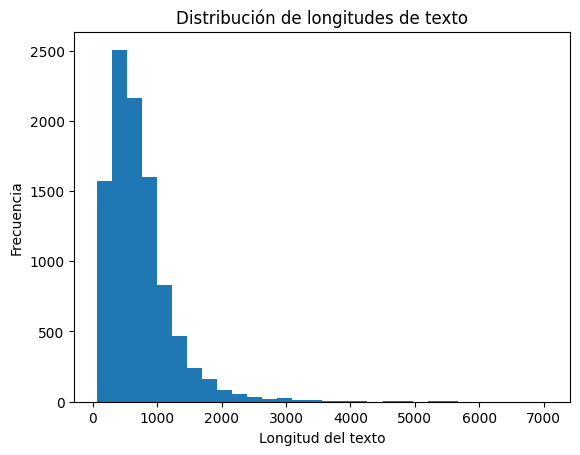

In [ ]:
import matplotlib.pyplot as plt

plt.hist(text_lengths, bins=30)
plt.xlabel('Longitud del texto')
plt.ylabel('Frecuencia')
plt.title('Distribución de longitudes de texto')
plt.show()


In [ ]:
print(sum([x is None for x in X_train]))  # Número de textos faltantes
print(sum([y is None for y in y_train]))  # Número de etiquetas faltantes


0
0


PESOS

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Asegúrate de que y_train sea un array 1D con las etiquetas únicas
y_train_w = np.argmax(y_train, axis=1)  # Si tus etiquetas están en formato one-hot
classes = np.unique(y_train_w)

# Calcular los pesos
class_weights = compute_class_weight(
    class_weight='balanced',  # Usar método "balanced" para ajustar automáticamente
    classes=classes,
    y=y_train_w
)

# Convertir a un diccionario (compatible con Keras)
class_weight_dict = dict(zip(classes, class_weights))

print("Pesos de clase:")
print(class_weight_dict)


ValueError: `axis` must be fewer than the number of dimensions (1)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Asegúrate de que y_train sea un array 1D con las etiquetas únicas
# If y_train is a pandas Series, convert it to a NumPy array
y_train_array = y_train.to_numpy()

# Check if y_train_array is 1-dimensional
if y_train_array.ndim == 1:
    y_train_w = y_train_array  # If it's already 1D, no need for argmax
else:
    y_train_w = np.argmax(y_train_array, axis=1)  # If it's one-hot encoded

classes = np.unique(y_train_w)

# Calcular los pesos
class_weights = compute_class_weight(
    class_weight='balanced',  # Usar método "balanced" para ajustar automáticamente
    classes=classes,
    y=y_train_w
)

# Convertir a un diccionario (compatible con Keras)
class_weight_dict = dict(zip(classes, class_weights))

print("Pesos de clase:")
print(class_weight_dict)

Pesos de clase:
{0: 0.8167277574141952, 1: 1.709205020920502, 2: 0.4826703426545884, 3: 8.422680412371134}


TOKENIZAR

In [ ]:
# Tokenización
max_words = 5000 ###depende de nuestros datos REVISISAR
max_len = 100
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

# Tokenizar
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
X_val = tokenizer.texts_to_sequences(X_val)


X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)
X_val = pad_sequences(X_val, maxlen=max_len)

print(X_test.shape)

(1233, 100)


PESOS

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Convert the Series to a NumPy array
y_train_array = y_train.to_numpy()

# If y_train contains one-hot encoded labels, use argmax:
# Check if the array is 2D. If not, assume it's not one-hot encoded.
if y_train_array.ndim == 2:
    y_train_w = np.argmax(y_train_array, axis=1)
else:
    y_train_w = y_train_array  # If not one-hot encoded, use as is

classes = np.unique(y_train_w)

# Calculate the weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train_w
)

# Convert to a dictionary
class_weight_dict = dict(zip(classes, class_weights))

print("Pesos de clase:")
print(class_weight_dict)

Pesos de clase:
{0: 0.8167277574141952, 1: 1.709205020920502, 2: 0.4826703426545884, 3: 8.422680412371134}


MODELO MLP CON EMBENDINGS
EMBENDINGS

In [ ]:
embedding_dim = 8

###Modelo

model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))
model.add(GlobalAveragePooling1D())  # Pooling layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(4, activation='softmax'))

# Compilar el modelo
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Resumen del modelo
model.summary()

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_val, y_val), class_weight=class_weight_dict )

# Evaluar el modelo en el conjunto de prueba
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ ?                           │     0 (unbuilt) │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.2623 - loss: 1.3923 - val_accuracy: 0.5049 - val_loss: 1.1061
Epoch 2/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5364 - loss: 1.1164 - val_accuracy: 0.5634 - val_loss: 0.9756
Epoch 3/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5831 - loss: 0.9360 - val_accuracy: 0.5873 - val_loss: 0.8885
Epoch 4/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6438 - loss: 0.7577 - val_accuracy: 0.5906 - val_loss: 0.9575
Epoch 5/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6809 - loss: 0.6715 - val_accuracy: 0.6219 - val_loss: 0.8862
Epoch 6/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7252 - loss: 0.5939 - val_accuracy: 0.6186 - val_loss: 0.9088
Epoch 7/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7472 - loss: 0.5423 - val_accuracy: 0.6236 - val_loss: 0.9407
Epoch 8/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7693 - loss: 0.4910 - val_accuracy: 0.

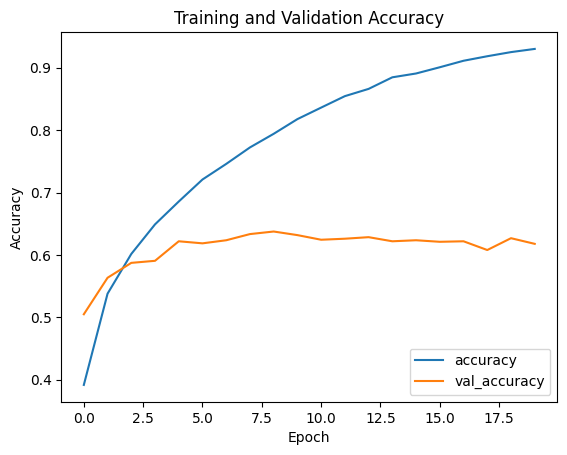

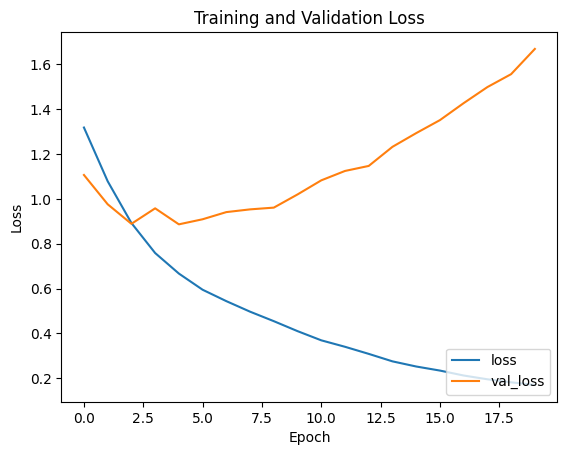

Test Accuracy: 0.6253 and Loss 1.8420


In [ ]:
# Gráficos de entrenamiento
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower right')
plt.show()


plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend(loc='lower right')
plt.show()

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {accuracy:.4f} and Loss {loss:.4f}")


39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


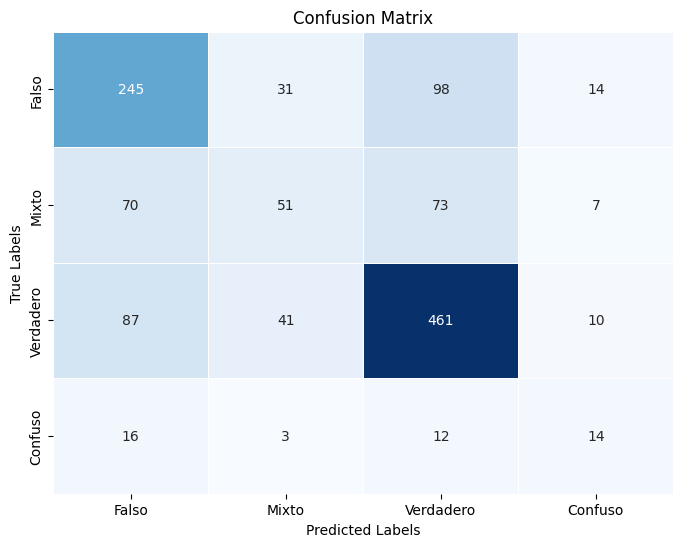

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

label = ["Falso", "Mixto", "Verdadero", "Confuso"]

# Matriz
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_m = np.argmax(y_test, axis=1)
# Compute confusion matrix
cm = confusion_matrix(y_test_m, y_pred)

# Create a heatmap with blue color palette
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=0.5, cbar=False, xticklabels=label, yticklabels=label)

# Set labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')


# Show the plot
plt.show()



39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


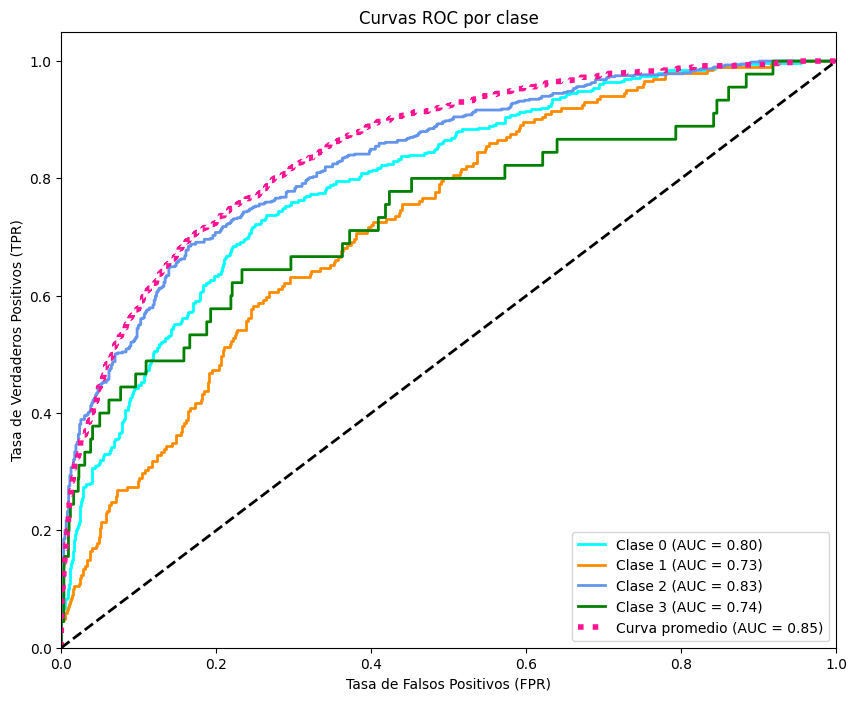

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

# Etiquetas verdaderas (One-Hot Encoding)
# Asegúrate de que y_test ya esté binarizado
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])  # Ejemplo con 4 clases

# Probabilidades predichas por el modelo
y_pred = model.predict(X_test)

# Número de clases
n_classes = y_test_bin.shape[1]

# Crear un diccionario para almacenar las curvas ROC
fpr = {}
tpr = {}
roc_auc = {}

# Calcular ROC para cada clase
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calcular la curva ROC promedio (macro)
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Graficar todas las curvas ROC
plt.figure(figsize=(10, 8))
colors = ['aqua', 'darkorange', 'cornflowerblue', 'green']
for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Clase {i} (AUC = {roc_auc[i]:.2f})')

# Agregar la curva ROC promedio
plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=4,
         label=f'Curva promedio (AUC = {roc_auc["micro"]:.2f})')

# Líneas y configuraciones
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC por clase')
plt.legend(loc="lower right")
plt.show()


MODELO CNN

In [ ]:
### MODELO CNN
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D
# Crear el modelo secuencial
modelCNN = keras.models.Sequential()
modelCNN.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))
modelCNN.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
modelCNN.add(MaxPooling1D(pool_size=4))
modelCNN.add(Dropout(0.3))
modelCNN.add(GlobalMaxPooling1D())
modelCNN.add(Dense(128, activation='relu'))
modelCNN.add(Dense(num_classes, activation='softmax'))

# Compilar el modelo
modelCNN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Resumen del modelo
modelCNN.summary()

###Entrenar el modelo

history = modelCNN.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_val, y_val), class_weight=class_weight_dict )

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_1               │ ?                           │     0 (unbuilt) │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.2863 - loss: 1.3804 - val_accuracy: 0.5478 - val_loss: 1.0544
Epoch 2/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.5409 - loss: 1.1108 - val_accuracy: 0.4876 - val_loss: 1.1054
Epoch 3/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.6399 - loss: 0.8080 - val_accuracy: 0.6120 - val_loss: 0.9024
Epoch 4/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.7259 - loss: 0.5598 - val_accuracy: 0.5832 - val_loss: 0.9469
Epoch 5/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.7821 - loss: 0.4328 - val_accuracy: 0.6112 - val_loss: 0.9637
Epoch 6/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.8261 - loss: 0.3498 - val_accuracy: 0.6285 - val_loss: 0.9926
Epoch 7/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.8707 - loss: 0.2646 - val_accuracy: 0.6326 - val_loss: 1.0749
Epoch 8/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.8968 - loss: 0.2120 - val_accuracy

In [ ]:
# Evaluar el modelo en el conjunto de prueba
test_loss, test_accuracy = modelCNN.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy}")

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5727 - loss: 2.3934
Test Accuracy: 0.587996780872345


GRÁFICOS

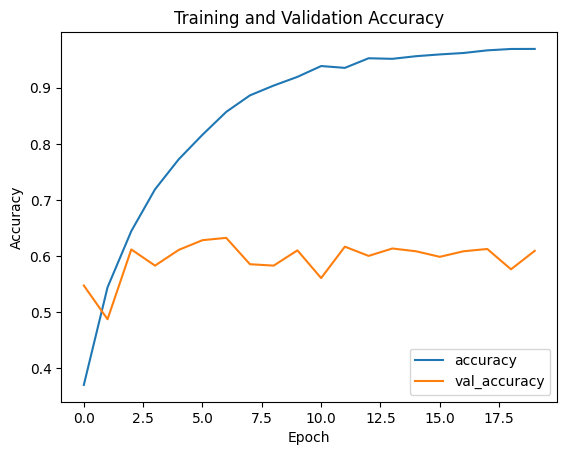

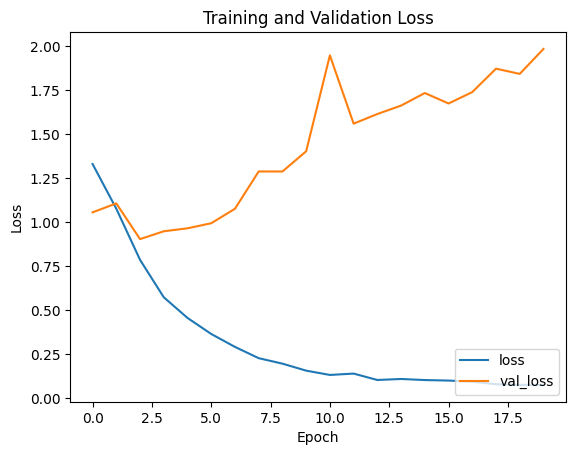

Test Accuracy: 0.6253 and Loss 1.8420


In [ ]:
# Gráficos de entrenamiento
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower right')
plt.show()


plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend(loc='lower right')
plt.show()

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {accuracy:.4f} and Loss {loss:.4f}")


MATRIZ

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


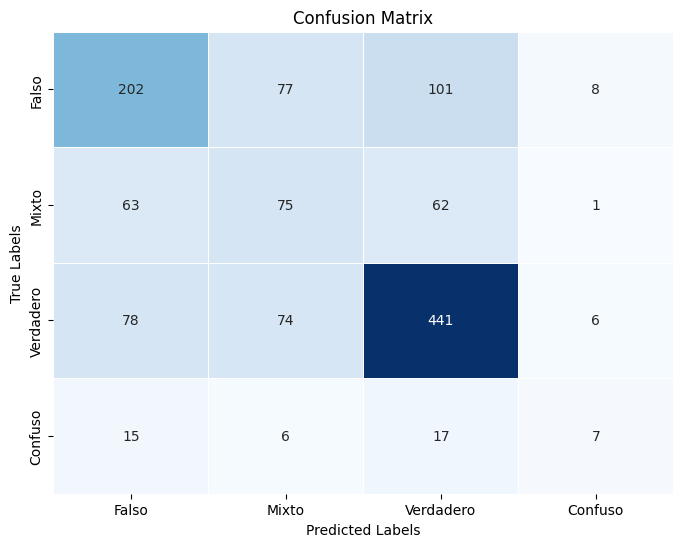

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

label = ["Falso", "Mixto", "Verdadero", "Confuso"]

# Matriz
y_pred = modelCNN.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_m = np.argmax(y_test, axis=1)
# Compute confusion matrix
cm = confusion_matrix(y_test_m, y_pred)

# Create a heatmap with blue color palette
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=0.5, cbar=False, xticklabels=label, yticklabels=label)

# Set labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')


# Show the plot
plt.show()


39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


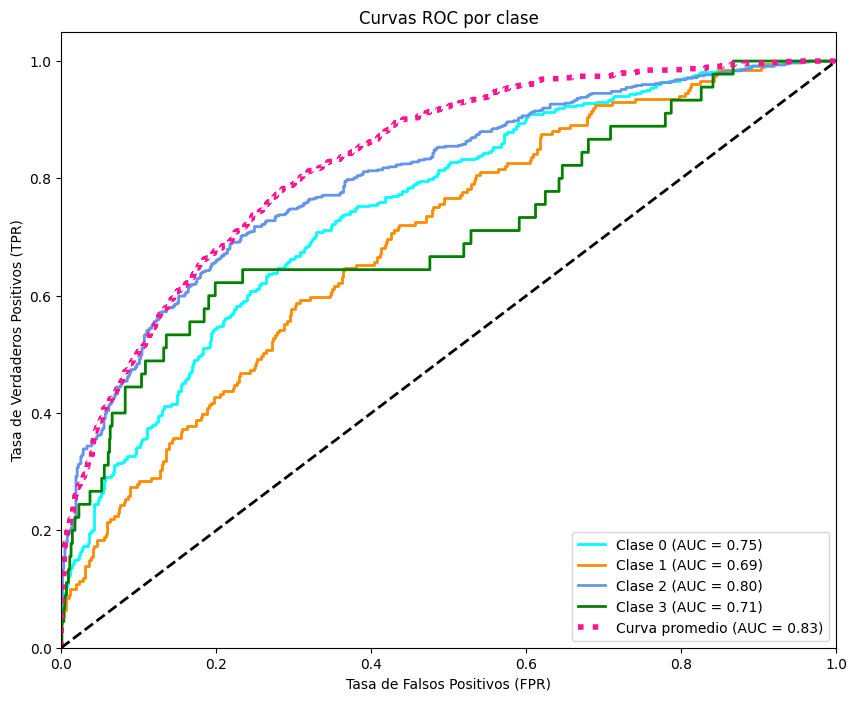

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

# Etiquetas verdaderas (One-Hot Encoding)
# Asegúrate de que y_test ya esté binarizado
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])  # Ejemplo con 4 clases

# Probabilidades predichas por el modelo
y_pred = modelCNN.predict(X_test)

# Número de clases
n_classes = y_test_bin.shape[1]

# Crear un diccionario para almacenar las curvas ROC
fpr = {}
tpr = {}
roc_auc = {}

# Calcular ROC para cada clase
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calcular la curva ROC promedio (macro)
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Graficar todas las curvas ROC
plt.figure(figsize=(10, 8))
colors = ['aqua', 'darkorange', 'cornflowerblue', 'green']
for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Clase {i} (AUC = {roc_auc[i]:.2f})')

# Agregar la curva ROC promedio
plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=4,
         label=f'Curva promedio (AUC = {roc_auc["micro"]:.2f})')

# Líneas y configuraciones
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC por clase')
plt.legend(loc="lower right")
plt.show()


RNN CON LSTM

In [ ]:
import tensorflow as tf
# Modelo
modelRNN = Sequential([
    Embedding(input_dim=max_words, output_dim=64),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(64, return_sequences=True),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])


# Compilar el modelo
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
modelRNN.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = modelRNN.fit(
    X_train, y_train,
    epochs=20,
    batch_size=24,
    validation_data=(X_val, y_val),
    class_weight=class_weight_dict
)

Epoch 1/20
409/409 ━━━━━━━━━━━━━━━━━━━━ 82s 184ms/step - accuracy: 0.4302 - loss: 1.3652 - val_accuracy: 0.5115 - val_loss: 1.1579
Epoch 2/20
409/409 ━━━━━━━━━━━━━━━━━━━━ 77s 187ms/step - accuracy: 0.4826 - loss: 1.1816 - val_accuracy: 0.5074 - val_loss: 1.1518
Epoch 3/20
409/409 ━━━━━━━━━━━━━━━━━━━━ 81s 185ms/step - accuracy: 0.5163 - loss: 1.0408 - val_accuracy: 0.4802 - val_loss: 1.0826
Epoch 4/20
409/409 ━━━━━━━━━━━━━━━━━━━━ 81s 183ms/step - accuracy: 0.5735 - loss: 0.8176 - val_accuracy: 0.5783 - val_loss: 0.9674
Epoch 5/20
409/409 ━━━━━━━━━━━━━━━━━━━━ 82s 185ms/step - accuracy: 0.6321 - loss: 0.7051 - val_accuracy: 0.5643 - val_loss: 0.9659
Epoch 6/20
409/409 ━━━━━━━━━━━━━━━━━━━━ 76s 185ms/step - accuracy: 0.6770 - loss: 0.6394 - val_accuracy: 0.6013 - val_loss: 1.0018
Epoch 7/20
409/409 ━━━━━━━━━━━━━━━━━━━━ 75s 184ms/step - accuracy: 0.7065 - loss: 0.5795 - val_accuracy: 0.5675 - val_loss: 1.0608
Epoch 8/20
409/409 ━━━━━━━━━━━━━━━━━━━━ 81s 183ms/step - accuracy: 0.7273 - loss: 0

In [ ]:
# Evaluar el modelo en el conjunto de prueba
test_loss, test_accuracy = modelRNN.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy}")

39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step - accuracy: 0.5427 - loss: 1.7633
Test Accuracy: 0.55474454164505


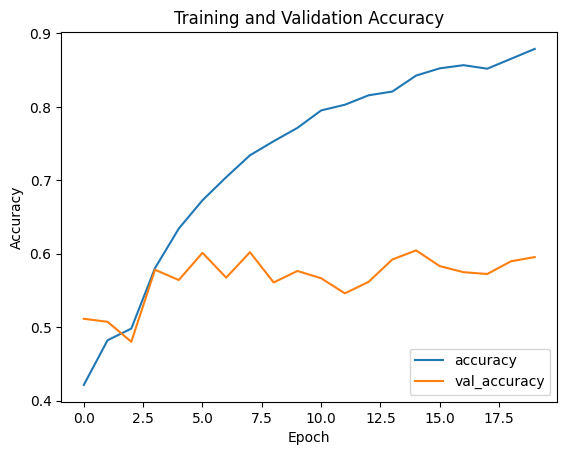

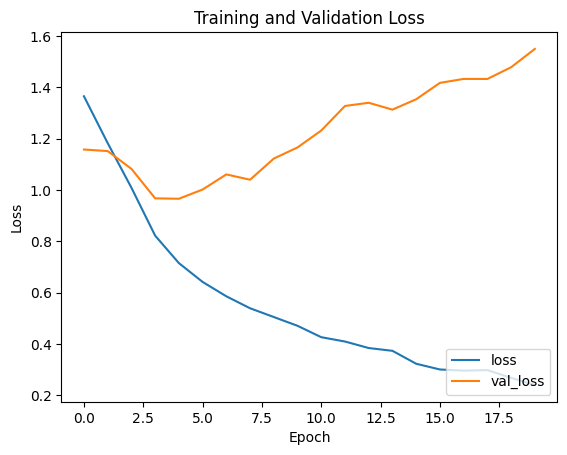

In [ ]:

# Gráficos de entrenamiento
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower right')
plt.show()


plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend(loc='lower right')
plt.show()

39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step


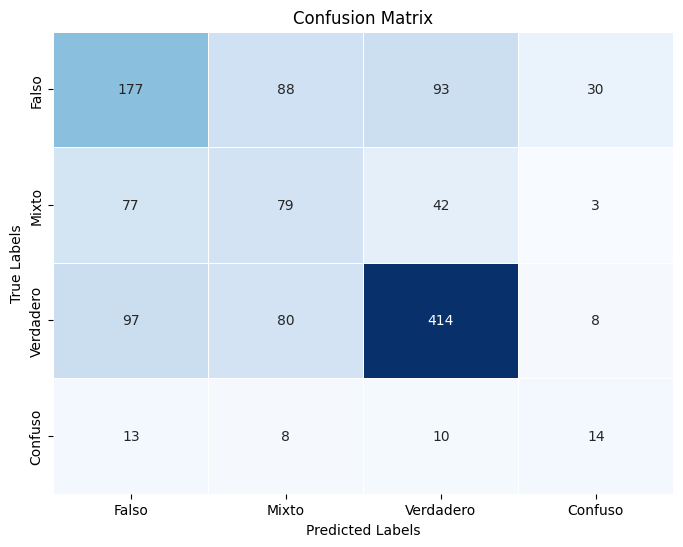

In [ ]:
# Matriz
y_pred = modelRNN.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_m = np.argmax(y_test, axis=1)
# Compute confusion matrix
cm = confusion_matrix(y_test_m, y_pred)

# Create a heatmap with blue color palette
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=0.5, cbar=False, xticklabels=label, yticklabels=label)

# Set labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')


# Show the plot
plt.show()

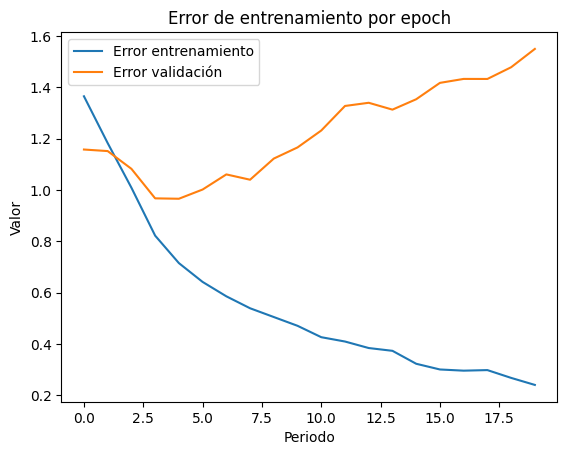

In [ ]:
plt.plot(history.history["loss"], label="Error entrenamiento")
plt.plot(history.history["val_loss"], label="Error validación")
plt.title("Error de entrenamiento por epoch")
plt.xlabel("Periodo")
plt.ylabel("Valor")
plt.legend()
plt.show()

39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step


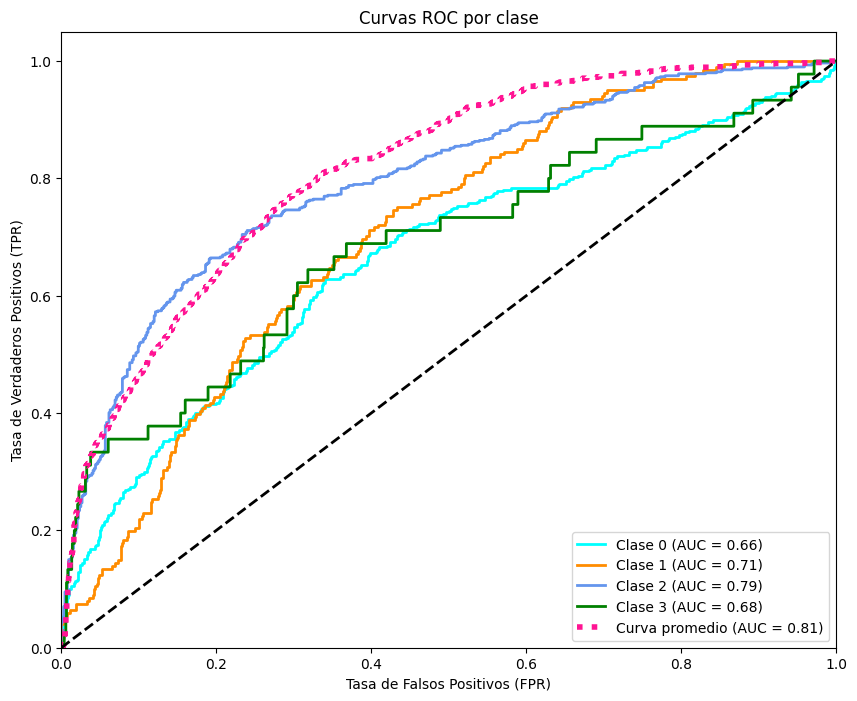

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

# Etiquetas verdaderas (One-Hot Encoding)
# Asegúrate de que y_test ya esté binarizado
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])  # Ejemplo con 4 clases

# Probabilidades predichas por el modelo
y_pred = modelRNN.predict(X_test)

# Número de clases
n_classes = y_test_bin.shape[1]

# Crear un diccionario para almacenar las curvas ROC
fpr = {}
tpr = {}
roc_auc = {}

# Calcular ROC para cada clase
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calcular la curva ROC promedio (macro)
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Graficar todas las curvas ROC
plt.figure(figsize=(10, 8))
colors = ['aqua', 'darkorange', 'cornflowerblue', 'green']
for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Clase {i} (AUC = {roc_auc[i]:.2f})')

# Agregar la curva ROC promedio
plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=4,
         label=f'Curva promedio (AUC = {roc_auc["micro"]:.2f})')

# Líneas y configuraciones
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC por clase')
plt.legend(loc="lower right")
plt.show()


MODELOS CON AJUSTE

STOPWORDS

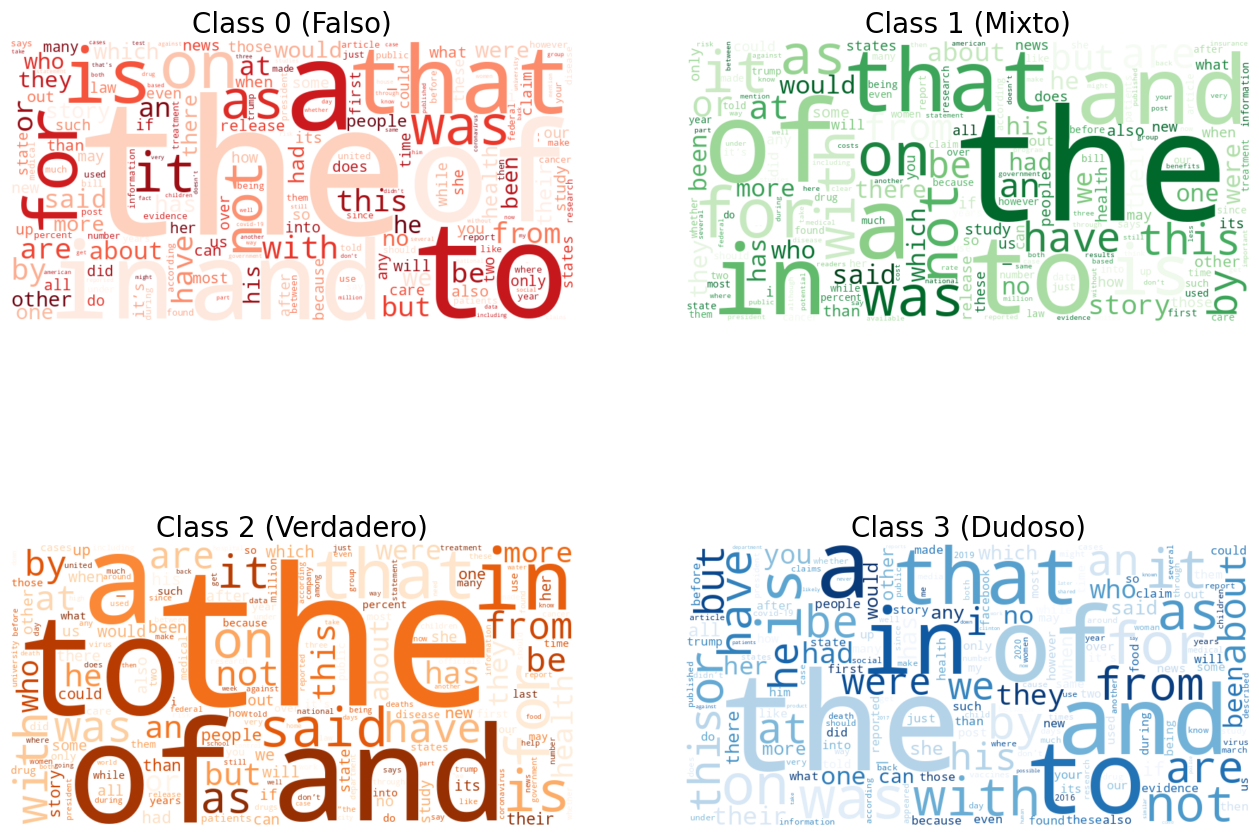

In [ ]:
# Hacer visualización en word cloud

# División basada en clase
text_0 = ' '.join(train[train['label'] == 0]['main_text'])
text_1 = ' '.join(train[train['label'] == 1]['main_text'])
text_2 = ' '.join(train[train['label'] == 2]['main_text'])
text_3 = ' '.join(train[train['label'] == 3]['main_text'])

# Frecuencia de palabras por clase
word_freq_0 = Counter(text_0.split())
word_freq_1 = Counter(text_1.split())
word_freq_2 = Counter(text_2.split())
word_freq_3 = Counter(text_3.split())

# Crear ambas nubes de palabras
wordcloud_0 = WordCloud(width=800, height=400, colormap='Reds', background_color='white').generate_from_frequencies(word_freq_0)
wordcloud_1 = WordCloud(width=800, height=400, colormap='Greens', background_color='white').generate_from_frequencies(word_freq_1)
wordcloud_2 = WordCloud(width=800, height=400, colormap='Oranges', background_color='white').generate_from_frequencies(word_freq_2)
wordcloud_3 = WordCloud(width=800, height=400, colormap='Blues', background_color='white').generate_from_frequencies(word_freq_3)

# Gráficos
plt.figure(figsize=(16, 12))
plt.subplot(2, 2, 1)
plt.imshow(wordcloud_0, interpolation='bilinear')
plt.title('Class 0 (Falso)', fontsize=20)
plt.axis('off')
plt.subplot(2, 2, 2)
plt.imshow(wordcloud_1, interpolation='bilinear')
plt.title('Class 1 (Mixto)', fontsize=20)
plt.axis('off')
plt.subplot(2, 2, 3)
plt.imshow(wordcloud_2, interpolation='bilinear')
plt.title('Class 2 (Verdadero)', fontsize=20)
plt.axis('off')
plt.subplot(2, 2, 4)
plt.imshow(wordcloud_3, interpolation='bilinear')
plt.title('Class 3 (Dudoso)', fontsize=20)
plt.axis('off')
plt.show()

In [ ]:
# Lista de palabras
stopwords = ['a', 'of', 'and','the', 'to', 'in', 'that', 'on', 'in', 'for', 'was', 'as']

# Función
def remove_stopwords(text, stopwords):
    return ' '.join([word for word in text.split() if word not in stopwords])

# Aplicar la función en el texto
train['main_text'] = train['main_text'].apply(lambda x: remove_stopwords(x, stopwords))
test['main_text'] = test['main_text'].apply(lambda x: remove_stopwords(x, stopwords))
val['main_text'] = val['main_text'].apply(lambda x: remove_stopwords(x, stopwords))

Etiqueta 0: 81584 palabras únicas
Etiqueta 1: 54253 palabras únicas
Etiqueta 2: 88526 palabras únicas
Etiqueta 3: 26151 palabras únicas
Promedio de palabras únicas por etiqueta: 62628.50


In [ ]:
train = pd.DataFrame(train)
test = pd.DataFrame(test)
val = pd.DataFrame(validation)


In [ ]:
# Seleccionar solo las columnas
X_train = train['main_text']
y_train = train['label']
X_val = val['main_text']
y_val = val['label']
X_test = test['main_text']
y_test = test['label']


CONTAR PALABRAS DESPUÉS DEL STOPWORDS

In [ ]:
# Combina todos los textos en una sola cadena
todo_el_texto = " ".join(X_train)

# Limpiar el texto (remover puntuación y pasar a minúsculas)
palabras = [palabra.strip(string.punctuation).lower() for palabra in todo_el_texto.split()]

# Crear un conjunto para obtener palabras únicas
palabras_unicas = set(palabras)

# Contar las palabras únicas
cantidad_palabras_unicas = len(palabras_unicas)

print(f"Cantidad de palabras únicas: {cantidad_palabras_unicas}")


Cantidad de palabras únicas: 153725


PALBRAS POR ETIQUETA

In [ ]:
import string

# Función para contar las palabras únicas por etiqueta y calcular el promedio
def contar_palabras_unicas_y_promedio(df):
    palabras_por_etiqueta = {}  # Diccionario para almacenar el número de palabras únicas por etiqueta
    total_palabras_unicas = 0  # Acumulador para el total de palabras únicas
    num_etiquetas = len(df['label'].unique())  # Número de etiquetas únicas

    # Iterar sobre cada etiqueta única en y_train
    for etiqueta in df['label'].unique():
        # Filtrar los textos que pertenecen a la etiqueta
        textos_etiqueta = df[df['label'] == etiqueta]['main_texto']

        # Unir todos los textos de esa etiqueta en un solo string
        todo_el_texto = " ".join(textos_etiqueta)

        # Limpiar el texto: quitar puntuación y poner todo en minúsculas
        palabras = [palabra.strip(string.punctuation).lower() for palabra in todo_el_texto.split()]

        # Crear un set de palabras únicas
        palabras_unicas = set(palabras)

        # Guardar el número de palabras únicas por etiqueta
        palabras_por_etiqueta[etiqueta] = len(palabras_unicas)

        # Acumular el total de palabras únicas
        total_palabras_unicas += len(palabras_unicas)

    # Calcular el promedio de palabras únicas por etiqueta
    promedio_palabras_unicas = total_palabras_unicas / num_etiquetas if num_etiquetas > 0 else 0

    return palabras_por_etiqueta, promedio_palabras_unicas

# Obtener las palabras únicas por etiqueta y el promedio
resultado, promedio = contar_palabras_unicas_y_promedio(df)

# Imprimir el resultado por etiqueta
for etiqueta, cantidad in resultado.items():
    print(f"Etiqueta {etiqueta}: {cantidad} palabras únicas")

# Imprimir el promedio global
print(f"Promedio de palabras únicas por etiqueta: {promedio:.2f}")


In [ ]:
###Hacer las clases categoricas

from tensorflow.keras.utils import to_categorical

num_classes = len(np.unique(y_train))

y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)
y_test = to_categorical(y_test, num_classes)
print(f"Train: {len(y_train)}, Validation: {len(y_val)}, Test: {len(y_test)}")

Train: 9804, Validation: 1225, Test: 1233


In [ ]:
print(f"Train: {len(X_train)}, Validation: {len(X_val)}, Test: {len(X_test)}")

Train: 9804, Validation: 1225, Test: 1233


In [ ]:
# Tokenización
max_words = 10000 ###depende de nuestros datos REVISISAR
max_len = 200
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

# Tokenizar
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
X_val = tokenizer.texts_to_sequences(X_val)


X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)
X_val = pad_sequences(X_val, maxlen=max_len)

print(X_test.shape)

(1233, 200)


MLP MODIFICADO: TASA ADAM MAS BAJA, dropaout mas alto  Y STOP EARLING

In [ ]:
embedding_dim = 16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
###Modelo

model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))
model.add(GlobalAveragePooling1D())  # Pooling layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

# Compilar el modelo
optimizer = Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer= optimizer, metrics=['accuracy'])

# Callback
early_stopping = EarlyStopping(
    monitor='val_loss',         # Metrica a monitorear
    patience=5,                 # Espera en numero de epochs/periodos a mejora
    verbose=1,
    restore_best_weights=True   # Devolver la corrida con mejores resultados
)

# Resumen del modelo
model.summary()

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_val, y_val),  callbacks= early_stopping,class_weight=class_weight_dict )

# Evaluar el modelo en el conjunto de prueba
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy}")

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_11 (Embedding)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_4           │ ?                           │     0 (unbuilt) │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.3558 - loss: 1.3717 - val_accuracy: 0.2245 - val_loss: 1.3716
Epoch 2/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.3807 - loss: 1.3704 - val_accuracy: 0.2620 - val_loss: 1.3481
Epoch 3/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.4412 - loss: 1.3898 - val_accuracy: 0.3241 - val_loss: 1.3343
Epoch 4/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5051 - loss: 1.3178 - val_accuracy: 0.3355 - val_loss: 1.3332
Epoch 5/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5056 - loss: 1.2879 - val_accuracy: 0.3314 - val_loss: 1.3324
Epoch 6/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.5099 - loss: 1.2221 - val_accuracy: 0.3535 - val_loss: 1.3246
Epoch 7/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5178 - loss: 1.2273 - val_accuracy: 0.3976 - val_loss: 1.3020
Epoch 8/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5336 - loss: 1.1318 - val_accuracy: 0.

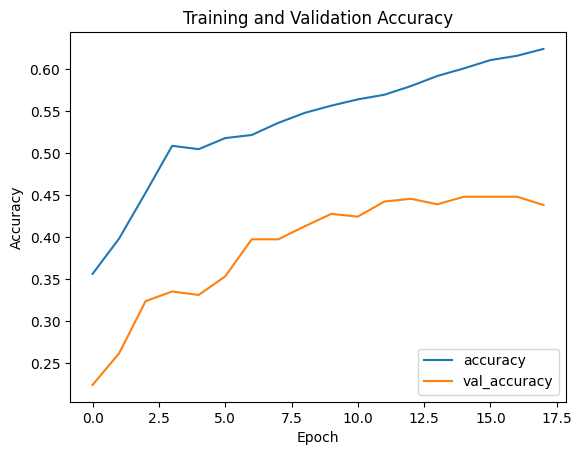

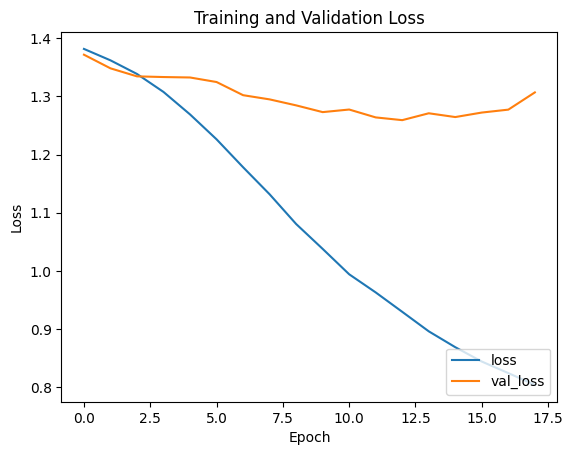

In [ ]:
# Gráficos de entrenamiento
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower right')
plt.show()


plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend(loc='lower right')
plt.show()

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


Text(0.5, 1.0, 'Confusion Matrix')

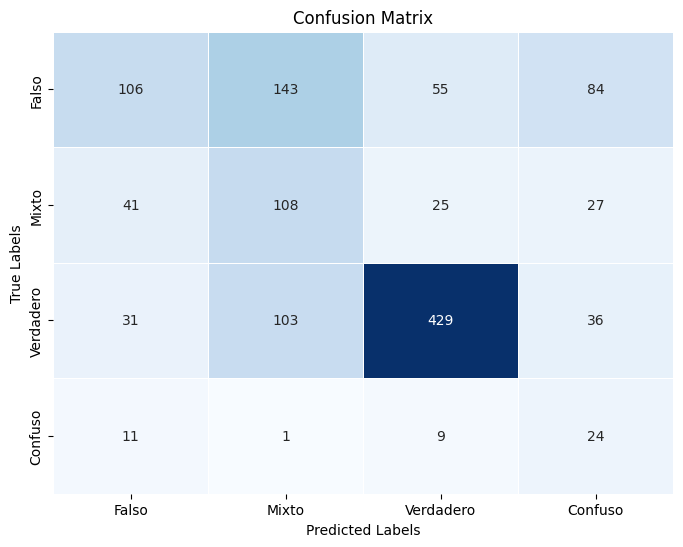

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

label = ["Falso", "Mixto", "Verdadero", "Confuso"]

# Matriz
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_m = np.argmax(y_test, axis=1)
# Compute confusion matrix
cm = confusion_matrix(y_test_m, y_pred)

# Create a heatmap with blue color palette
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=0.5, cbar=False, xticklabels=label, yticklabels=label)

# Set labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')


CURVA ROC

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


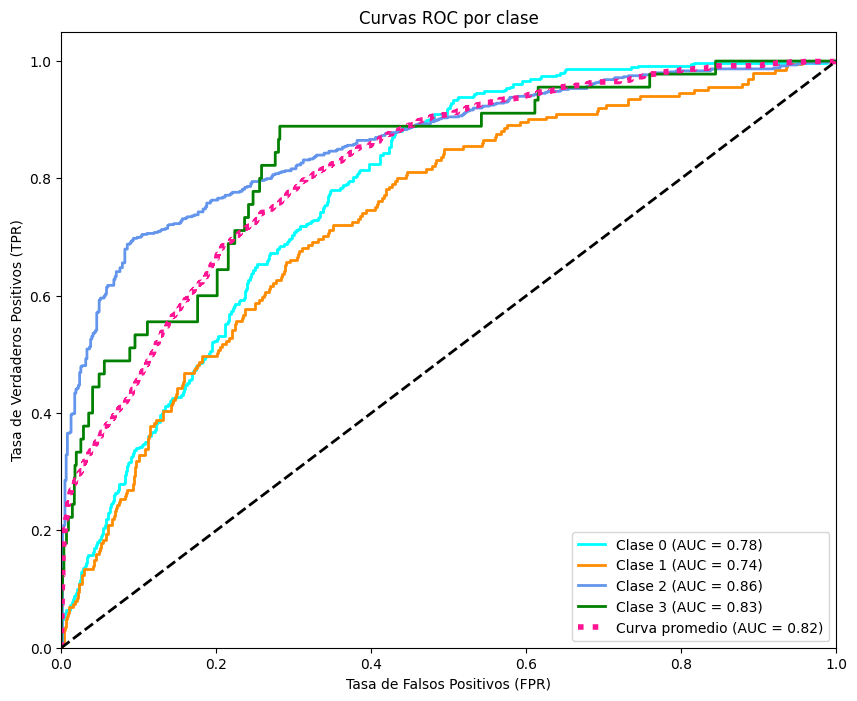

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

# Etiquetas verdaderas (One-Hot Encoding)
# Asegúrate de que y_test ya esté binarizado
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])  # Ejemplo con 4 clases

# Probabilidades predichas por el modelo
y_pred = model.predict(X_test)

# Número de clases
n_classes = y_test_bin.shape[1]

# Crear un diccionario para almacenar las curvas ROC
fpr = {}
tpr = {}
roc_auc = {}

# Calcular ROC para cada clase
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calcular la curva ROC promedio (macro)
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Graficar todas las curvas ROC
plt.figure(figsize=(10, 8))
colors = ['aqua', 'darkorange', 'cornflowerblue', 'green']
for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Clase {i} (AUC = {roc_auc[i]:.2f})')

# Agregar la curva ROC promedio
plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=4,
         label=f'Curva promedio (AUC = {roc_auc["micro"]:.2f})')

# Líneas y configuraciones
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC por clase')
plt.legend(loc="lower right")
plt.show()


MODELO CNN CON STOP EARLING, OTRA TASA DE APPRENDIZAJE Y DROPOUT MAS ALTO Y MAYOR DIM EMBEDDING

In [ ]:
### MODELO CNN
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D
# Crear el modelo secuencial
modelCNN1 = keras.models.Sequential()
modelCNN1.add(Embedding(input_dim=max_words, output_dim=16, input_length=max_len))
modelCNN1.add(Conv1D(filters=64, kernel_size=3, activation='relu', strides=1, padding='same'))
modelCNN1.add(MaxPooling1D(pool_size=1, padding='same'))
modelCNN1.add(Dropout(0.5))
modelCNN1.add(GlobalMaxPooling1D())
modelCNN1.add(Dense(128, activation='relu'))
modelCNN1.add(Dense(num_classes, activation='softmax'))

# Compilar el modelo
optimizer = Adam(learning_rate=0.0001)
modelCNN1.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callback
early_stopping = EarlyStopping(
    monitor='val_loss',         # Metrica a monitorear
    patience=5,                 # Espera en numero de epochs/periodos a mejora
    verbose=1,
    restore_best_weights=True   # Devolver la corrida con mejores resultados
)

# Resumen del modelo
modelCNN1.summary()

###Entrenar el modelo

history = modelCNN1.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_val, y_val), callbacks= early_stopping)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_27 (Embedding)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_19 (Conv1D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_17 (MaxPooling1D)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_16              │ ?                           │     0 (unbuilt) │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_46 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_47 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.4399 - loss: 1.2367 - val_accuracy: 0.5135 - val_loss: 1.1290
Epoch 2/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.5329 - loss: 1.0290 - val_accuracy: 0.5837 - val_loss: 1.0836
Epoch 3/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.5606 - loss: 1.0014 - val_accuracy: 0.5910 - val_loss: 1.0484
Epoch 4/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.6007 - loss: 0.9282 - val_accuracy: 0.6367 - val_loss: 1.0047
Epoch 5/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.6438 - loss: 0.8611 - val_accuracy: 0.6514 - val_loss: 0.9788
Epoch 6/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.6664 - loss: 0.8176 - val_accuracy: 0.6604 - val_loss: 0.9568
Epoch 7/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.6763 - loss: 0.7835 - val_accuracy: 0.6678 - val_loss: 0.9592
Epoch 8/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.7080 - loss: 0.7467 - val_ac

In [ ]:
# Evaluar el modelo en el conjunto de prueba
test_loss, test_accuracy = modelCNN1.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy}")

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6579 - loss: 0.8650
Test Accuracy: 0.6699107885360718


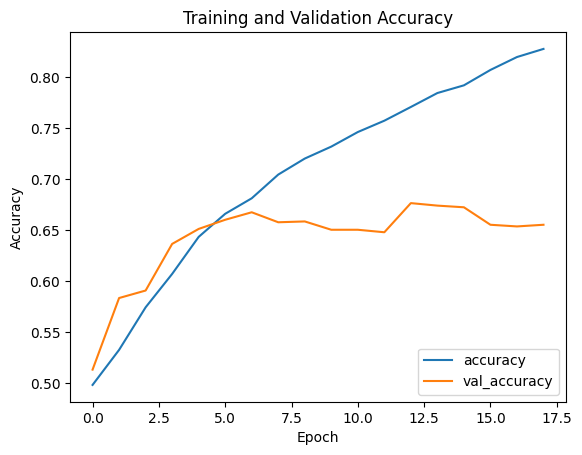

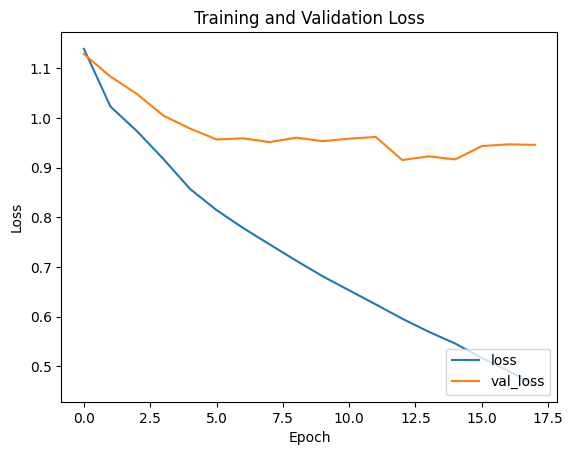

In [ ]:
# Gráficos de entrenamiento
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower right')
plt.show()


plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend(loc='lower right')
plt.show()

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


Text(0.5, 1.0, 'Confusion Matrix')

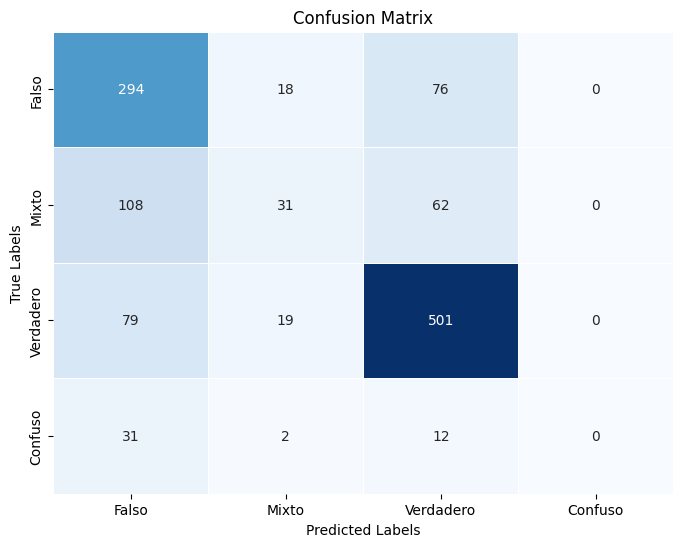

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

label = ["Falso", "Mixto", "Verdadero", "Confuso"]

# Matriz
y_pred = modelCNN1.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_m = np.argmax(y_test, axis=1)
# Compute confusion matrix
cm = confusion_matrix(y_test_m, y_pred)

# Create a heatmap with blue color palette
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=0.5, cbar=False, xticklabels=label, yticklabels=label)

# Set labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')


39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


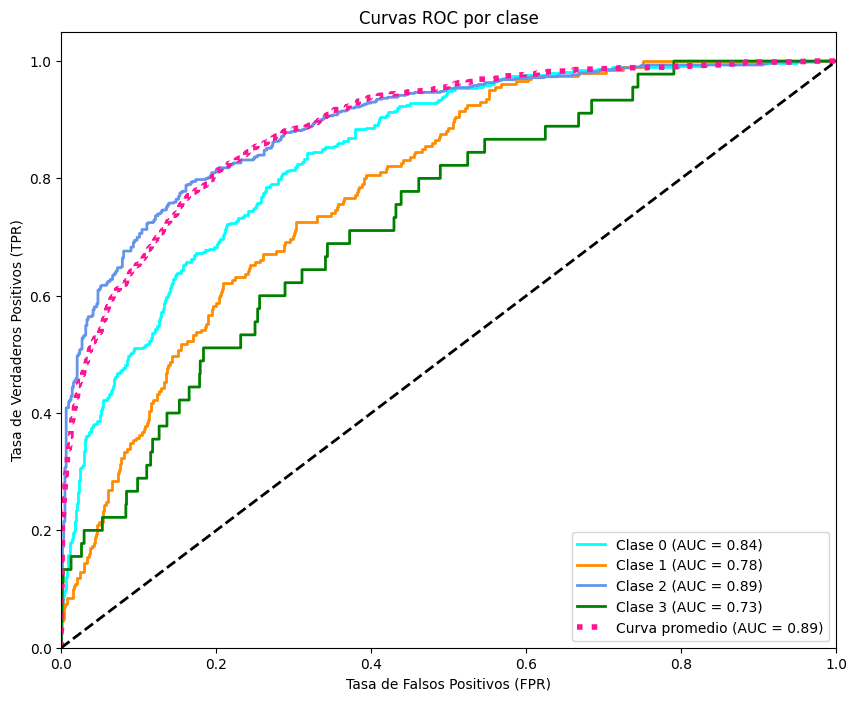

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

# Etiquetas verdaderas (One-Hot Encoding)
# Asegúrate de que y_test ya esté binarizado
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])  # Ejemplo con 4 clases

# Probabilidades predichas por el modelo
y_pred = modelCNN1.predict(X_test)

# Número de clases
n_classes = y_test_bin.shape[1]

# Crear un diccionario para almacenar las curvas ROC
fpr = {}
tpr = {}
roc_auc = {}

# Calcular ROC para cada clase
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calcular la curva ROC promedio (macro)
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Graficar todas las curvas ROC
plt.figure(figsize=(10, 8))
colors = ['aqua', 'darkorange', 'cornflowerblue', 'green']
for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Clase {i} (AUC = {roc_auc[i]:.2f})')

# Agregar la curva ROC promedio
plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=4,
         label=f'Curva promedio (AUC = {roc_auc["micro"]:.2f})')

# Líneas y configuraciones
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC por clase')
plt.legend(loc="lower right")
plt.show()

RNN CON GRU, OTRA TASA STOP EARLING Y DROPOUT DIFERENTE

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import  GRU

# Modelo
# Modelo
modelRNN1 = Sequential([
    Embedding(input_dim=max_words, output_dim=16),
    GRU(64, return_sequences=True),
    Dropout(0.5),
    GRU(64, return_sequences=True),
    GRU(64, return_sequences=False),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])


# Compilar el modelo
modelRNN1.compile(optimizer= 'adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callback
early_stopping = EarlyStopping(
    monitor='val_loss',         # Metrica a monitorear
    patience=5,                 # Espera en numero de epochs/periodos a mejora
    verbose=1,
    restore_best_weights=True   # Devolver la corrida con mejores resultados
)

# Train the model
history = modelRNN1.fit(
    X_train, y_train,
    epochs=20,
    batch_size=24,
    validation_data=(X_val, y_val),
    class_weight=class_weight_dict,
    callbacks= early_stopping
)

# Evaluar el modelo en el conjunto de prueba
test_loss, test_accuracy = modelRNN1.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy}")

Epoch 1/20
409/409 ━━━━━━━━━━━━━━━━━━━━ 166s 390ms/step - accuracy: 0.3565 - loss: 1.3727 - val_accuracy: 0.4367 - val_loss: 1.1950
Epoch 2/20
409/409 ━━━━━━━━━━━━━━━━━━━━ 160s 391ms/step - accuracy: 0.5232 - loss: 1.0816 - val_accuracy: 0.4816 - val_loss: 1.2031
Epoch 3/20
409/409 ━━━━━━━━━━━━━━━━━━━━ 200s 388ms/step - accuracy: 0.6267 - loss: 0.7694 - val_accuracy: 0.5061 - val_loss: 1.2399
Epoch 4/20
409/409 ━━━━━━━━━━━━━━━━━━━━ 158s 387ms/step - accuracy: 0.7010 - loss: 0.5967 - val_accuracy: 0.4220 - val_loss: 1.4344
Epoch 5/20
409/409 ━━━━━━━━━━━━━━━━━━━━ 204s 393ms/step - accuracy: 0.7635 - loss: 0.4782 - val_accuracy: 0.4384 - val_loss: 1.5847
Epoch 6/20
409/409 ━━━━━━━━━━━━━━━━━━━━ 200s 389ms/step - accuracy: 0.7838 - loss: 0.4577 - val_accuracy: 0.5412 - val_loss: 1.4263
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.4727 - loss: 1.1018
Test Accuracy: 0.4622870981693268


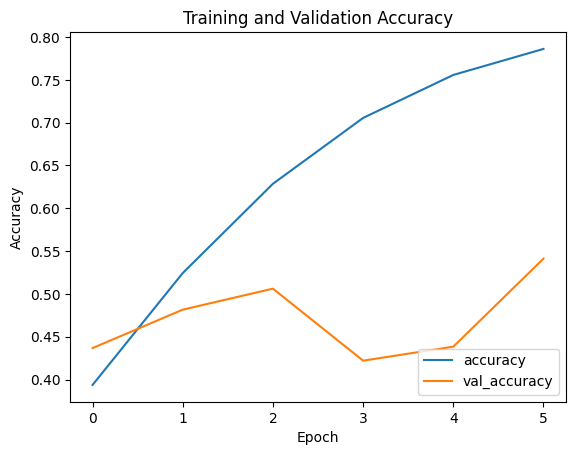

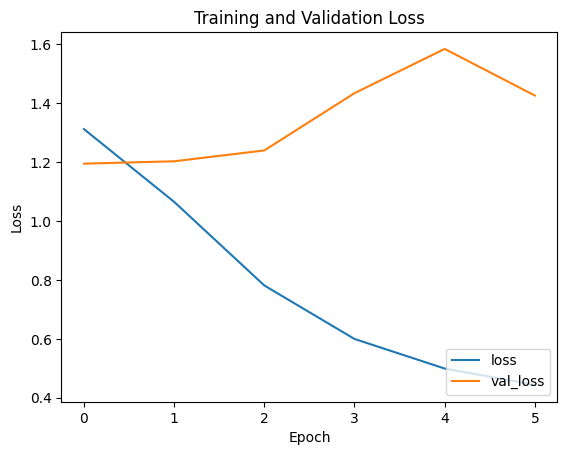

In [ ]:
# Gráficos de entrenamiento
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower right')
plt.show()


plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend(loc='lower right')
plt.show()

39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step


Text(0.5, 1.0, 'Confusion Matrix')

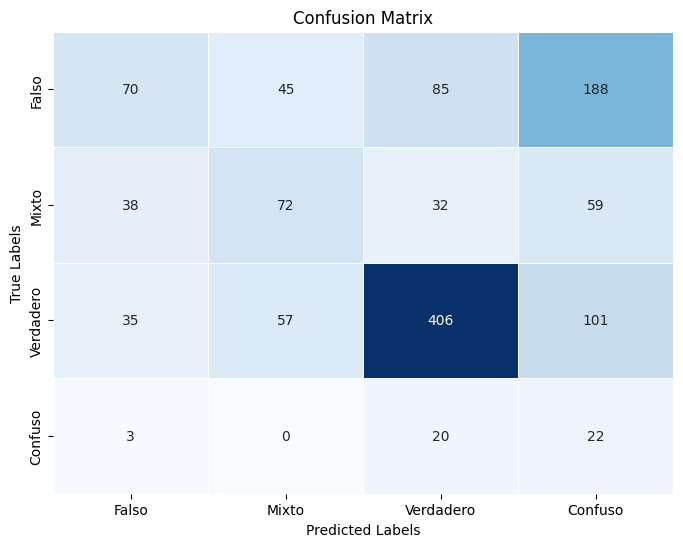

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

label = ["Falso", "Mixto", "Verdadero", "Confuso"]

# Matriz
y_pred = modelRNN1.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_m = np.argmax(y_test, axis=1)
# Compute confusion matrix
cm = confusion_matrix(y_test_m, y_pred)

# Create a heatmap with blue color palette
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=0.5, cbar=False, xticklabels=label, yticklabels=label)

# Set labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step


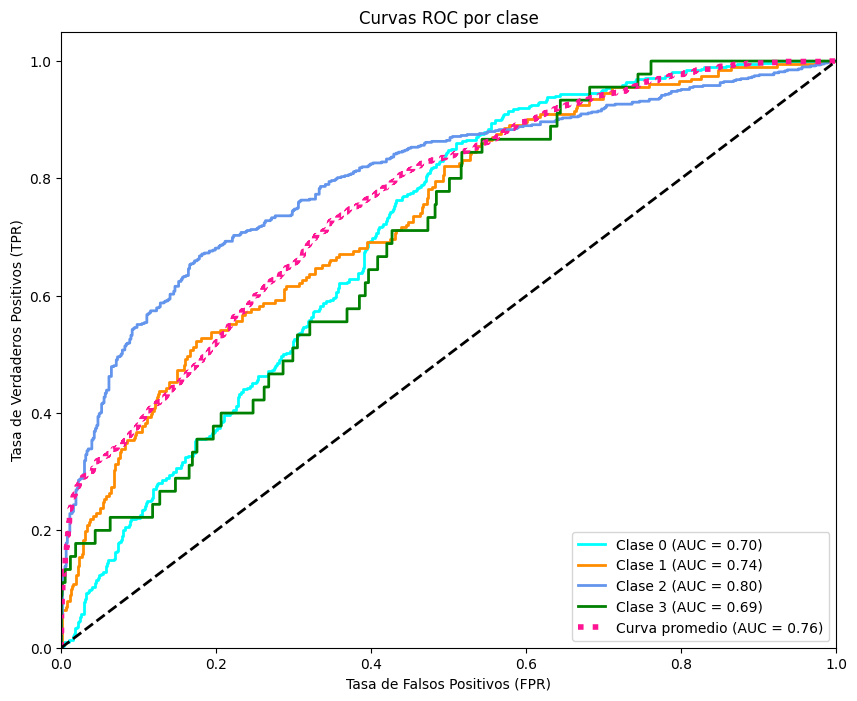

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

# Etiquetas verdaderas (One-Hot Encoding)
# Asegúrate de que y_test ya esté binarizado
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])  # Ejemplo con 4 clases

# Probabilidades predichas por el modelo
y_pred = modelRNN1.predict(X_test)

# Número de clases
n_classes = y_test_bin.shape[1]

# Crear un diccionario para almacenar las curvas ROC
fpr = {}
tpr = {}
roc_auc = {}

# Calcular ROC para cada clase
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calcular la curva ROC promedio (macro)
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Graficar todas las curvas ROC
plt.figure(figsize=(10, 8))
colors = ['aqua', 'darkorange', 'cornflowerblue', 'green']
for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Clase {i} (AUC = {roc_auc[i]:.2f})')

# Agregar la curva ROC promedio
plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=4,
         label=f'Curva promedio (AUC = {roc_auc["micro"]:.2f})')

# Líneas y configuraciones
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC por clase')
plt.legend(loc="lower right")
plt.show()

MODELOS CON MAYOR LONGITUD

In [ ]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense

# Define max_length and max_words
max_length = 500  # Reemplaza con la longitud máxima de tus secuencias
max_words = 15000  # Reemplaza con el número máximo de palabras en tu vocabulario
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

# Tokenizar
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
X_val = tokenizer.texts_to_sequences(X_val)


X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)
X_val = pad_sequences(X_val, maxlen=max_len)

print(X_test.shape)


# Modelo
model = Sequential([
    Embedding(input_dim=max_words, output_dim=64, input_length=max_length),
    LSTM(32, return_sequences=True),
    Dropout(0.5),
    LSTM(32, return_sequences=True, kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    LSTM(32, kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(num_classes, activation='softmax')
])

In [ ]:
import tensorflow as tf # Import the tensorflow library
# Compilar el modelo
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=16,
    validation_data=(X_val, y_val)
)

In [ ]:
# Gráficos de entrenamiento
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower right')
plt.show()


plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend(loc='lower right')
plt.show()
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {accuracy:.4f} and Loss {loss:.4f}")
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix # Import confusion_matrix

# Matriz
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_m = np.argmax(y_test, axis=1)
# Compute confusion matrix
cm = confusion_matrix(y_test_m, y_pred)

labels_names= ["Falso", "Mixto", "Verdadero", "Confuso"]

# Create a heatmap with blue color palette
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=0.5, cbar=False, xticklabels=labels_names, yticklabels=labels_names)

# Set labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
